In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
from glob import glob
import xarray
import numpy
from e3smplot.e3sm_utils import can_retrieve_field, get_data, open_dataset

In [6]:
# Find files
output_path = '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127'
all_files = glob(f'{output_path}/*.eam.h[0-9].*.nc')
cloud_files = [f for f in all_files if can_retrieve_field(f, 'CLDLIQ')]

In [7]:
# Load data
ds = xarray.open_mfdataset(sorted(cloud_files)[-1], chunks={'time': 1}).isel(time=0)

In [17]:
# Compute a cloud mask based on a threshold of liquid and ice water content
def get_liq_cloud_mask(ds, threshold=1e-5):
    cldliq = get_data(ds, 'CLDLIQ')
    cld_mask = cldliq.where(cldliq > threshold).notnull() #(cldliq > threshold)
    cld_mask.attrs = {
        'long_name': 'Liquid cloud mask',
        'units': 'none',
        'description': f'CLDLIQ > {threshold}',
    }
    return cld_mask

def get_ice_cloud_mask(ds, threshold=1e-5):
    cldice = get_data(ds, 'CLDICE')
    cld_mask = cldice.where(cldice > threshold).notnull() #(cldice > threshold)
    cld_mask.attrs = {
        'long_name': 'Ice cloud mask',
        'units': 'none',
        'description': f'CLDICE > {threshold}',
    }
    return cld_mask

def get_cloud_mask(ds):
    liq_mask = get_liq_cloud_mask(ds)
    ice_mask = get_ice_cloud_mask(ds)
    cld_mask = (liq_mask * ice_mask).notnull() #((liq_mask > 0) | (ice_mask > 0))
    cld_mask.attrs = {
        'long_name': 'Cloud mask',
        'units': 'none',
        'description': f'{liq_mask.attrs["description"]} | {ice_mask.attrs["description"]}',
    }
    return cld_mask

In [18]:
liq_mask = get_liq_cloud_mask(ds)
ice_mask = get_ice_cloud_mask(ds)
cld_mask = get_cloud_mask(ds)
cldliq = get_data(ds, 'CLDLIQ')
cldice = get_data(ds, 'CLDICE')

In [19]:
num_samples = 5
test_columns = numpy.random.randint(0, cldliq.ncol.size, num_samples)

In [20]:
test_columns

array([  647340, 19075904, 22344432, 10562227, 19365165])

In [ ]:
cldliq.sel(ncol=test_columns).max().values

In [ ]:
from matplotlib import pyplot
figure, axes = pyplot.subplots(2, 2, figsize=(10,10))
for ivar, data in enumerate([cldliq, liq_mask, cldice, ice_mask]):
    ax = figure.add_axes(axes.ravel()[ivar])
    pl = ax.pcolormesh(data.sel(ncol=test_columns))
    #ax.set_title(data.attrs['long_name'])
    cb = pyplot.colorbar(pl, orientation='horizontal',
                        label=f'{data.long_name}')

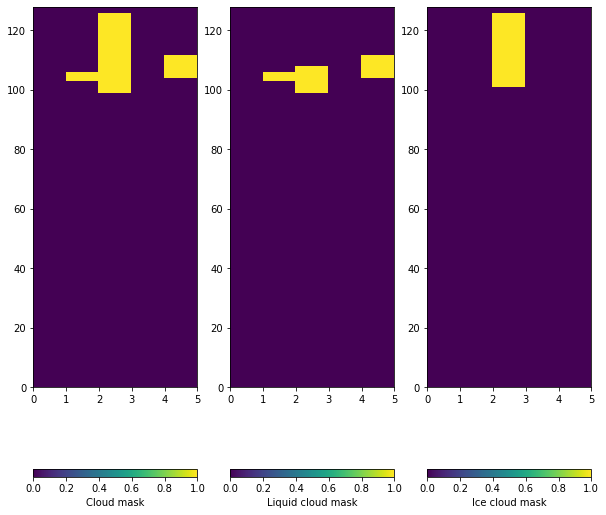

In [12]:
from matplotlib import pyplot
figure, axes = pyplot.subplots(1, 3, figsize=(10,10))
for ivar, data in enumerate([cld_mask, liq_mask, ice_mask]):
    ax = figure.add_axes(axes.ravel()[ivar])
    pl = ax.pcolormesh(data.sel(ncol=test_columns))
    #ax.set_title(data.attrs['long_name'])
    cb = pyplot.colorbar(pl, orientation='horizontal',
                        label=f'{data.long_name}')

In [13]:
# Vertically-projected cloud area (shadow)
def get_cloud_area(ds):
    # First get 3D cloud mask
    cld_mask = get_cloud_mask(ds)
    # Project down
    cld_area = (cld_mask > 0).any(dim='lev')
    cld_area.attrs = {
        'long_name': 'Cloud area mask',
        'units': 'none',
        'description': 'any(cld_mask > 0)',
    }
    return cld_area

In [ ]:
from matplotlib import pyplot
figure, axes = pyplot.subplots(1, 1, figsize=(10,10))
ax = figure.add_axes(axes)
pl = ax.pcolormesh(numpy.arange(len(test_columns)+1), numpy.arange(cld_mask.lev.size+1), cld_mask.sel(ncol=test_columns), cmap='Greys')
#ax.set_title(data.attrs['long_name'])
cb = pyplot.colorbar(pl, orientation='horizontal',
                    label=f'{data.long_name}')

cld_area = get_cloud_area(ds)
pl = ax.plot(numpy.arange(len(test_columns))+0.5, cld_area.where(cld_area>0).sel(ncol=test_columns), 'kx')

In [17]:
numpy.arange

<function numpy.arange>

In [17]:
cld_mask

<xarray.DataArray (lev: 128, ncol: 25165824)>
dask.array<or_, shape=(128, 25165824), dtype=bool, chunksize=(128, 25165824), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
    time     object 2020-02-05 00:00:00
Dimensions without coordinates: ncol
Attributes:
    long_name:    Cloud mask
    units:        none
    description:  CLDLIQ > 1e-05 | CLDICE > 1e-05

In [23]:
def get_data(ds, field):
    if field in ds.variables.keys():
        data = ds[field]
    elif field == 'LIQ_MASK':
        data = get_liq_cloud_mask(dataset)
    elif field == 'ICE_MASK':
        data = get_ice_cloud_mask(dataset)
    elif field == 'CLD_MASK':
        data = get_cloud_mask(dataset)
    return data

In [ ]:
from matplotlib import pyplot
from glob import glob
from e3smplot.e3sm_utils import open_dataset, get_data, get_area_weights, area_average, can_retrieve_field
# Compare time series of CLDTOT, LIQ_MASK, ICE_MASK, CLD_MASK
variable_names = ('LIQ_MASK',)#'CLDTOT', 'LIQ_MASK', 'ICE_MASK', 'CLD_MASK')
output_path = '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127'
all_files = glob(f'{output_path}/*.eam.h[0-9].*.nc')
figure, ax = pyplot.subplots(1, 1) # figsize=(10, 10))

for ivar, v in enumerate(variable_names):
    # find files
    print(v)
    these_files = [f for f in all_files if can_retrieve_field(f, v)]
    
    # Load files
    print('load dataset')
    ds = open_dataset(sorted(these_files), chunks={'time': 1})
    
    # Get data
    print('get data')
    data = get_data(ds, v)

    # Compute area averages
    print('compute averages')
    w = get_area_weights(ds)
    m = area_average(data, w, dims=[d for d in data.dims if d != 'time'])
    
    # Convert units
    print('Convert units')
    if data.attrs['units'] == 'none':
        m = 100.0 * m
        m.attrs['units'] = '%'
        
    # Plot timeseries
    print('plot')
    pl = ax.plot(data.time, m, label=v)
    
    ds.close()
    
lh = pyplot.legend(pl)

LIQ_MASK
load dataset
get data
compute averages
Convert units
plot


In [ ]:
print('foo')

In [2]:
all_files

['/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/SCREAMv0.SCREAM-DY2.ne1024pg2.20201127.eam.h7.2020-02-02-00000.nc',
 '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/SCREAMv0.SCREAM-DY2.ne1024pg2.20201127.eam.h0.2020-01-24-00000.nc',
 '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/SCREAMv0.SCREAM-DY2.ne1024pg2.20201127.eam.h1.2020-01-22-00000.nc',
 '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/SCREAMv0.SCREAM-DY2.ne1024pg2.20201127.eam.h8.2020-01-30-00000.nc',
 '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/SCREAMv0.SCREAM-DY2.ne1024pg2.20201127.eam.h7.2020-01-28-00000.nc',
 '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/SCREAMv0.SCREAM-DY2.ne1024pg2.20201127.eam.h0.2020-01-27-00000.nc',
 '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/SCREAMv0.SCREAM-DY2.ne1024pg2.20201127.eam.h2.2020-01-20-00000.nc',
 '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127/SCREAMv0.SCREAM-DY2.